Project Analysis

For this binary classification problem, I decided to choose from Naive Bayes and SVM.
Because dataset is highly correlated, it would not be rational to use Random Forest or Decision Trees 
as they cannot work to full potential with multicollinearity.


In [30]:
import pandas, numpy
import matplotlib.pyplot as plt 
import seaborn as sns
import constants
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

In [31]:
feature_dataset = pandas.read_csv("ready_dataset.csv").drop(columns=['client_id', 'Unnamed: 0'])
feature_dataset.head(100)


,has_car,has_realty,income_category,education_category,married,living_place,has_mobile_phone,has_work_phone,has_phone,has_email,job,employed,exp_applicant,bad_client,Female,Male,total_children,age,annual_income,family_size
0,True,True,4,1,True,4,True,True,True,True,0,True,False,False,False,True,-0.580439,0.239169,0.757090,-0.215761
1,False,True,4,3,False,4,True,False,False,False,18,True,False,False,True,False,0.816766,-1.165751,-0.687067,-0.215761
2,True,True,0,3,True,4,True,False,True,False,4,True,False,False,False,True,-0.580439,1.117244,-0.687067,-0.215761
3,True,True,0,3,True,4,True,False,True,False,4,True,False,False,False,True,-0.580439,1.117244,-0.687067,-0.215761
4,True,True,0,3,True,4,True,False,True,False,4,True,False,False,False,True,-0.580439,1.117244,-0.687067,-0.215761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,True,False,4,1,True,5,True,True,False,False,3,True,False,False,False,True,-0.580439,-1.341366,-0.191927,-0.215761
96,True,False,0,1,True,4,True,True,False,False,10,True,False,False,False,True,2.213972,-0.199868,2.201246,2.025300
97,False,True,1,3,True,4,True,False,True,False,18,False,False,False,True,False,-0.580439,1.380667,-0.274450,-0.215761
98,False,True,1,3,True,4,True,False,True,False,18,False,False,False,True,False,-0.580439,1.380667,-0.274450,-0.215761


In [14]:
feature_dataset.describe()

,income_category,education_category,living_place,job,total_children,age,annual_income,family_size
count,473735.000000,473735.000000,473735.000000,473735.000000,4.737350e+05,4.737350e+05,4.737350e+05,4.737350e+05
mean,2.374931,2.422407,3.913768,10.782013,-2.303806e-17,-1.099108e-16,-4.688606e-17,6.886221e-16
std,1.722445,0.896511,0.572576,5.938582,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,0.000000,0.000000,0.000000,0.000000,-5.804388e-01,-2.043827e+00,-1.479289e+00,-1.336291e+00
25%,1.000000,1.000000,4.000000,6.000000,-5.804388e-01,-8.145212e-01,-6.045433e-01,-2.157609e-01
50%,4.000000,3.000000,4.000000,10.000000,-5.804388e-01,-1.120610e-01,-2.331888e-01,-2.157609e-01
75%,4.000000,3.000000,4.000000,18.000000,8.167664e-01,8.538219e-01,3.444737e-01,9.047696e-01
max,4.000000,4.000000,5.000000,18.000000,2.596646e+01,2.258742e+00,6.017381e+01,1.995379e+01


Correlation between features

<Axes: >

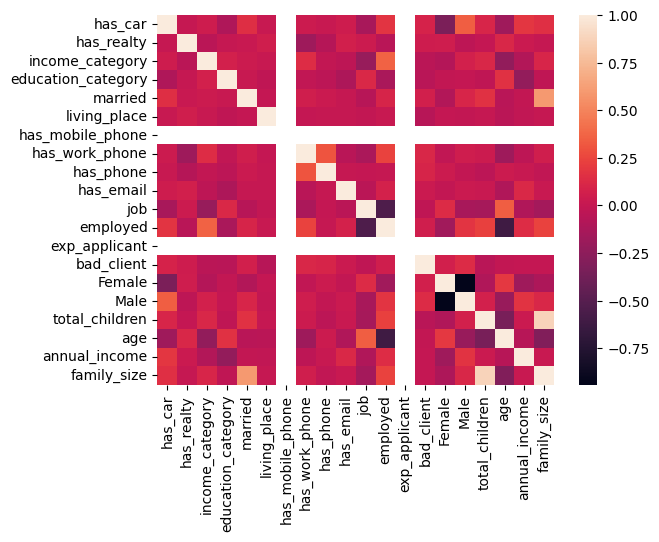

In [32]:
sns.heatmap(feature_dataset.corr())

In [37]:
# Splitting data into training, testing and validation sets 
from sklearn.model_selection import train_test_split 

def split_data(feature_dataset):
    
    x_set, y_set = feature_dataset.drop(columns=["bad_client"], inplace=False), feature_dataset['bad_client']

    # Splitting into training and test sets
    x_train, x_test, y_train, y_test = train_test_split(
    x_set, y_set, test_size=0.5, stratify=y_set, random_state=1)

    # Splitting into training and validation sets 
    x_test, validation_x_set, y_test, validation_y_set = train_test_split(
    x_test, y_test, test_size=0.5, stratify=y_test, random_state=1)

    return (x_train, y_train), (x_test, y_test), (validation_x_set, validation_y_set)

training_set, test_set, validation_set = split_data(feature_dataset)

In [38]:
print('training_set - ', len(training_set[0]))
print('testing_set - ', len(test_set[0]))
print('validation_set - ', len(validation_set[0]))

training_set -  236867
testing_set -  118434
validation_set -  118434


In [34]:
xg_model = xgb.XGBClassifier()

Hyperparameter Tuning for XGBoost using GridSearchCV

In [ ]:
# Selecting models and apply hyperparameter tuning

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, log_loss # loss function for binary classification model

loss_function = make_scorer(
    log_loss, greater_is_better=False, 
    needs_proba=True
)

xg_hyperparams = {
    "learning_rate": [],
    "max_depth": [],
}  

new_cvs = GridSearchCV(
    estimator=xg_model,
    param_grid=xg_hyperparams,
    scoring=loss_function,
    cv=StratifiedKFold(n_splits=5),
    error_score="raise",
    n_jobs=-1,
)

new_cvs.fit(test_set[0], test_set[1])
    
    # the lower loss score is, the better model performs 

optimal_params = new_cvs.best_params_
loss_score = new_cvs.best_score_

opt_model = xgb.XGBClassifier(**optimal_params)


Feature Selection using RFE (Recursive Feature Elimination)

In [35]:
from sklearn.feature_selection import RFECV


estimator = RFECV(
    estimator=opt_model, 
    step=2, min_features_to_select=5,
    cv=StratifiedKFold(n_splits=5),
    scoring='accuracy',
)

    # fitting the model 
estimator.fit(training_set[0], training_set[1])
    
features_idxs = list(
    filter(
        lambda feature: estimator.support_[feature] == True,
        range(len(training_set[0].columns))
    )
)

feature_func = (lambda feature: training_set[0].columns[feature])

res = {
    'features': feature_func(features_idxs),
    'metrics': numpy.mean(estimator.cv_results_['mean_test_score'])    
}
res


{'features': Index(['has_car', 'has_realty', 'income_category', 'education_category',
        'married', 'living_place', 'has_work_phone', 'has_phone', 'has_email',
        'job', 'employed', 'Female', 'Male', 'total_children', 'age',
        'annual_income', 'family_size'],
       dtype='object'),
 'metrics': 0.982954347117384}

Splitting important data for validation set

In [ ]:
validation_set[0] = validation_set[0][res['features']]

Cross-validating model on validation set

In [40]:
from sklearn.model_selection import cross_validate 

scorers = ["precision", "recall", "accuracy"]

scores = cross_validate(
    estimator=opt_model,
    X=validation_set[0],
    y=validation_set[1],
    scoring=scorers
)

print('accuracy - ', numpy.mean(scores['test_accuracy']))
print('precision - ', numpy.mean(scores['test_precision']))
print('recall - ', numpy.mean(scores['test_recall']))

NameError: name 'opt_model' is not defined

In [39]:
res['features']

Index(['has_car', 'has_realty', 'income_category', 'education_category',
       'married', 'living_place', 'has_work_phone', 'has_phone', 'has_email',
       'job', 'employed', 'Female', 'Male', 'total_children', 'age',
       'annual_income', 'family_size'],
      dtype='object')

In [257]:
# saving machine learning model using pickle 
import pickle 
pickle.dump(opt_model, open("classifier.pkl", mode="wb"))